In [1]:
%load_ext autoreload
%autoreload 2
import time
import copy
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F

from utils.metrics import AverageMeter, accuracy
from figure import plot_classes_preds
from torchsummaryX import summary

from utils.utils import show_test_acc, show_profile, configuration
from dataset import get_dataloader, get_test_dataloader
from models.model import get_network
import matplotlib.pyplot as plt


**********START LOGGING, GPU: 0 **********

[ NETWORK ]  resnet34
None
[MODEL] Number of parameters :  21328292
for_trainNval :     CIFAR100
Cifar100 Dataloader
Files already downloaded and verified
Files already downloaded and verified
DATALOADER FOR ALL CLASS
Done!
labels:  tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
        98., 99.])
0.0%
0.09%
0.18%
0.26%
0.35%
0.44%
0.53%
0.62%
0.71%
0.79%
0.88%
0.97%


/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

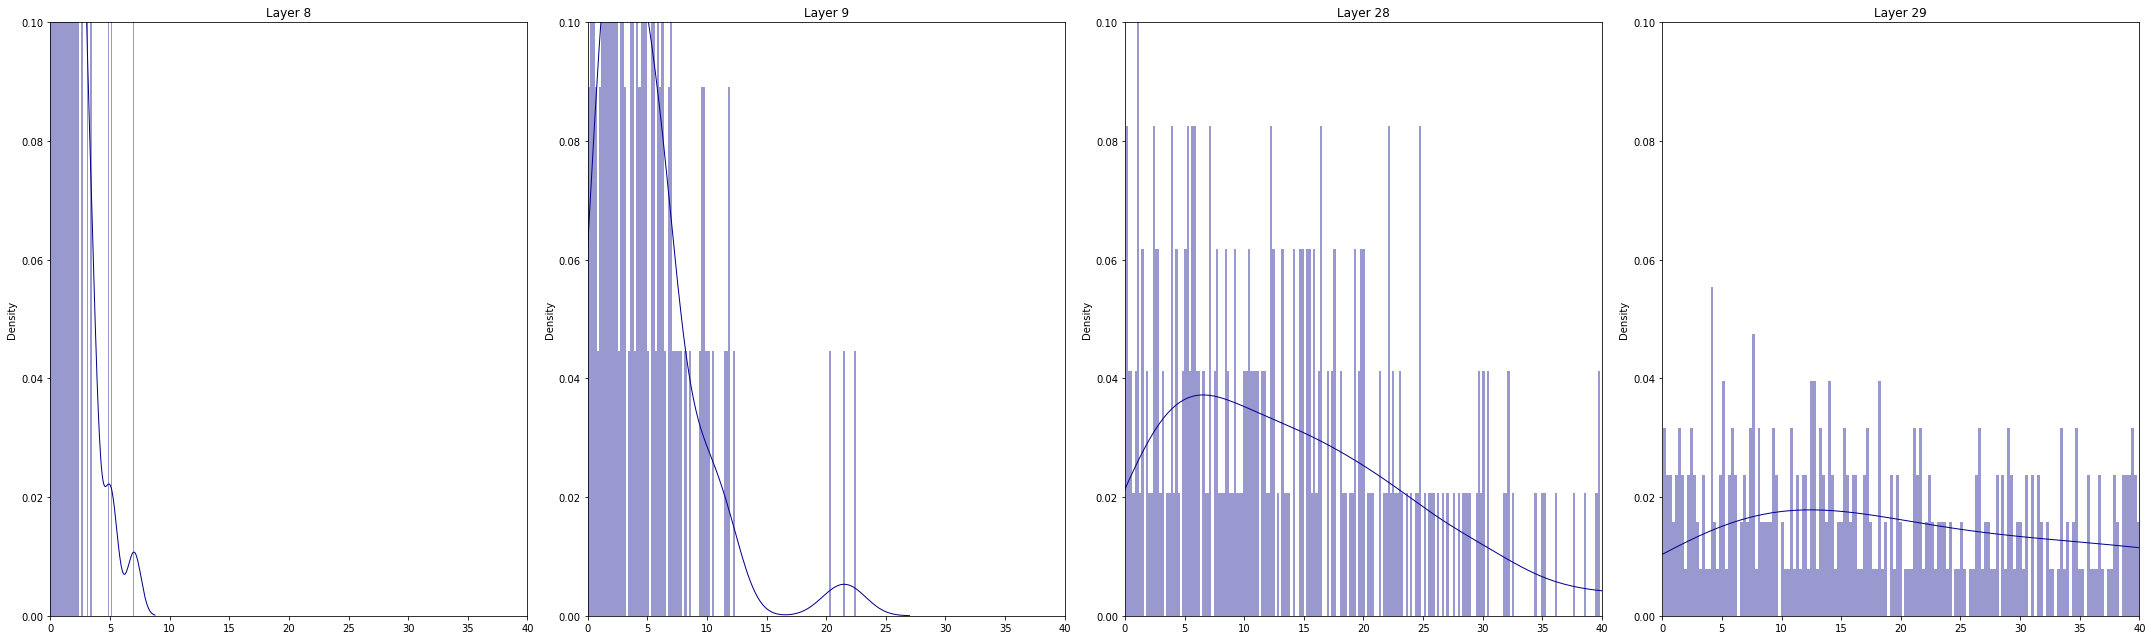

In [167]:
import seaborn as sns
######################################################resnet34
cfg, writer = configuration('default.yml', '0', jupyter=True)
network = get_network(cfg['network'], 100)
state_dict_path = 'models/pretrained/resnet34_cifar100.pt'
network.load_state_dict(torch.load(state_dict_path),  strict=False)

dataloader, n_class = get_dataloader(cfg)
get_test_dataloader(cfg, dataloader, get_only_targets=True)
inputs = get_inputs(dataloader)
target_classes = cfg['data'].get('target_classes', [0,1,2,3,4])
targets = inputs[target_classes]
non_targets = inputs[list(set(list(range(100)))-set(target_classes))]


r_alls = []
r_targets = []
for layer_idx in range(34):
    out = get_output_r34(network, layer_idx, non_targets)  # (95, c, 8, 8)
    norm = torch.norm(out, dim=(2,3)).detach().numpy()  # (95, c)
    ranking = ss.rankdata(norm, axis=1, method='min')
    ranking = np.mean(ranking, axis=0)
    r_alls.append(ranking)
        
    out = get_output_r34(network, layer_idx, targets)
    norm = torch.norm(out, dim=(2,3)).detach().numpy()  # (95, c)
    ranking = ss.rankdata(norm, axis=1, method='min')
    ranking = np.mean(ranking, axis=0)
    r_targets.append(ranking)
    
    if layer_idx % 3 == 0:
        print(f"{round(layer_idx/34, 2)}%")
        
        
selected_idx = [7, 8, 27, 28]
plt.figure(figsize=(30, 9)) 
c = 0
for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
#     if layer_idx != 32:
#         plt.axis('off')
    if layer_idx in selected_idx:
        plt.subplot(1, 4, c+1)
        c += 1
        diff = np.abs(t-a)
        sns.distplot(diff, hist=True, kde=True, 
                     bins=int(len(diff)), color = 'darkblue', 
                     kde_kws={'linewidth': 1})

        plt.xlim(0, 40)
        plt.ylim(0, 0.1)
        plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()

plt.savefig(f'figures/diff_histogram_r34_{selected_idx}.png')
plt.show()

In [149]:
import seaborn as sns
######################################################resnet18
cfg, writer = configuration('default_r18.yml', '0', jupyter=True)
network = get_network(cfg['network'], 100)
state_dict_path = 'models/pretrained/resnet18_cifar100.pt'
network.load_state_dict(torch.load(state_dict_path),  strict=False)

dataloader, n_class = get_dataloader(cfg)
get_test_dataloader(cfg, dataloader, get_only_targets=True)
inputs = get_inputs(dataloader)
target_classes = cfg['data'].get('target_classes', [0,1,2,3,4])
targets = inputs[target_classes]
non_targets = inputs[list(set(list(range(100)))-set(target_classes))]


r_alls = []
r_targets = []
for layer_idx in range(18):
    out = get_output_r18(network, layer_idx, non_targets)  # (95, c, 8, 8)
    norm = torch.norm(out, dim=(2,3)).detach().numpy()  # (95, c)
    ranking = ss.rankdata(norm, axis=1, method='min')
    ranking = np.mean(ranking, axis=0)
    r_alls.append(ranking)
        
    out = get_output_r18(network, layer_idx, targets)
    norm = torch.norm(out, dim=(2,3)).detach().numpy()  # (95, c)
    ranking = ss.rankdata(norm, axis=1, method='min')
    ranking = np.mean(ranking, axis=0)
    r_targets.append(ranking)
    
    if layer_idx % 3 == 0:
        print(f"{round(layer_idx/34, 2)}%")
        


**********START LOGGING, GPU: 0 **********

[ NETWORK ]  resnet18
None
[MODEL] Number of parameters :  11220132
for_trainNval :     CIFAR100
Cifar100 Dataloader
Files already downloaded and verified
Files already downloaded and verified
DATALOADER FOR ALL CLASS
Done!
labels:  tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
        98., 99.])
0.0%
0.09%
0.18%
0.26%
0.35%
0.44%


/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

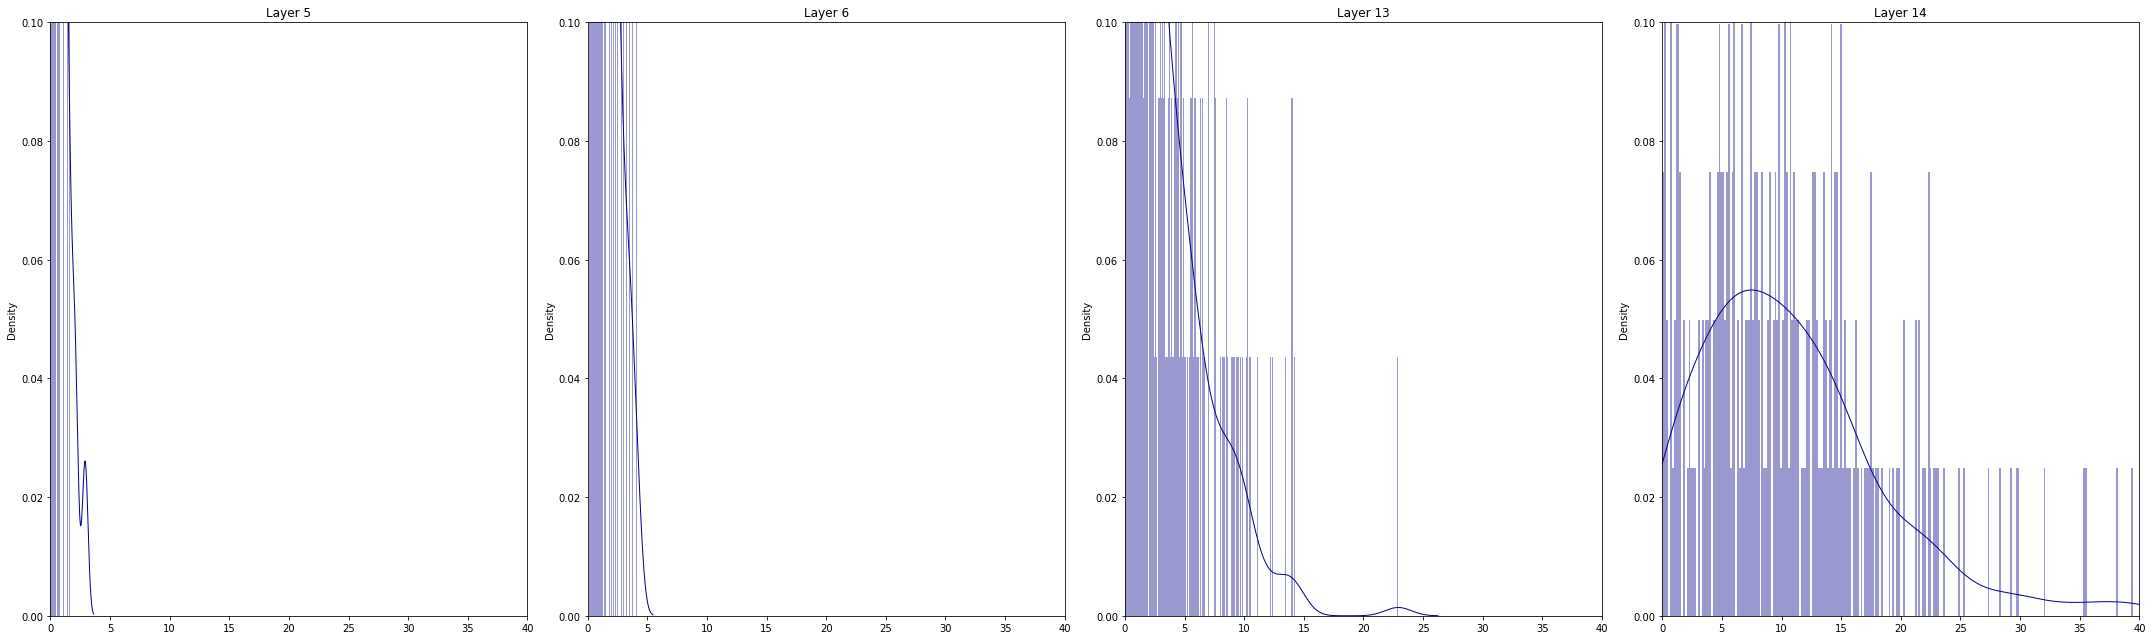

In [158]:
 
selected_idx = [4, 5,12,13]
plt.figure(figsize=(30, 9)) 
c = 0
for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
#     if layer_idx != 32:
#         plt.axis('off')
    if layer_idx in selected_idx:
        plt.subplot(1, 4, c+1)
        c += 1
        diff = np.abs(t-a)
        sns.distplot(diff, hist=True, kde=True, 
                     bins=int(len(diff)), color = 'darkblue', 
                     kde_kws={'linewidth': 1})

        plt.xlim(0, 40)
        plt.ylim(0, 0.1)
        plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()

plt.savefig(f'figures/diff_histogram_r18_{selected_idx}2.png')
plt.show()

In [160]:
import seaborn as sns
###################################################### vgg16
cfg, writer = configuration('default_vgg.yml', '0', jupyter=True)
network = get_network(cfg['network'], 100)
state_dict_path = 'models/pretrained/vgg16_bn_cifar100_f12.pt'
network.load_state_dict(torch.load(state_dict_path),  strict=False)

dataloader, n_class = get_dataloader(cfg)
get_test_dataloader(cfg, dataloader, get_only_targets=True)
inputs = get_inputs(dataloader)
target_classes = cfg['data'].get('target_classes', [0,1,2,3,4])
targets = inputs[target_classes]
non_targets = inputs[list(set(list(range(100)))-set(target_classes))]


r_alls = []
r_targets = []
out1, out2 = get_output_vgg(network, layer_idx, non_targets)  # (95, c, 8, 8)
norm = torch.norm(out1, dim=(2,3)).detach().numpy()  # (95, c)
ranking = ss.rankdata(norm, axis=1, method='min')
ranking = np.mean(ranking, axis=0)
r_alls.append(ranking)
norm = torch.norm(out2, dim=(2,3)).detach().numpy()  # (95, c)
ranking = ss.rankdata(norm, axis=1, method='min')
ranking = np.mean(ranking, axis=0)
r_alls.append(ranking)

out1, out2 = get_output_vgg(network, layer_idx, targets)
norm = torch.norm(out1, dim=(2,3)).detach().numpy()  # (95, c)
ranking = ss.rankdata(norm, axis=1, method='min')
ranking = np.mean(ranking, axis=0)
r_targets.append(ranking)
norm = torch.norm(out2, dim=(2,3)).detach().numpy()  # (95, c)
ranking = ss.rankdata(norm, axis=1, method='min')
ranking = np.mean(ranking, axis=0)
r_targets.append(ranking)

        


**********START LOGGING, GPU: 0 **********

[ NETWORK ]  vgg_16_bn
None
[MODEL] Number of parameters :  15038116
for_trainNval :     CIFAR100
Cifar100 Dataloader
Files already downloaded and verified
Files already downloaded and verified
DATALOADER FOR ALL CLASS
Done!
labels:  tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
        98., 99.])


/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


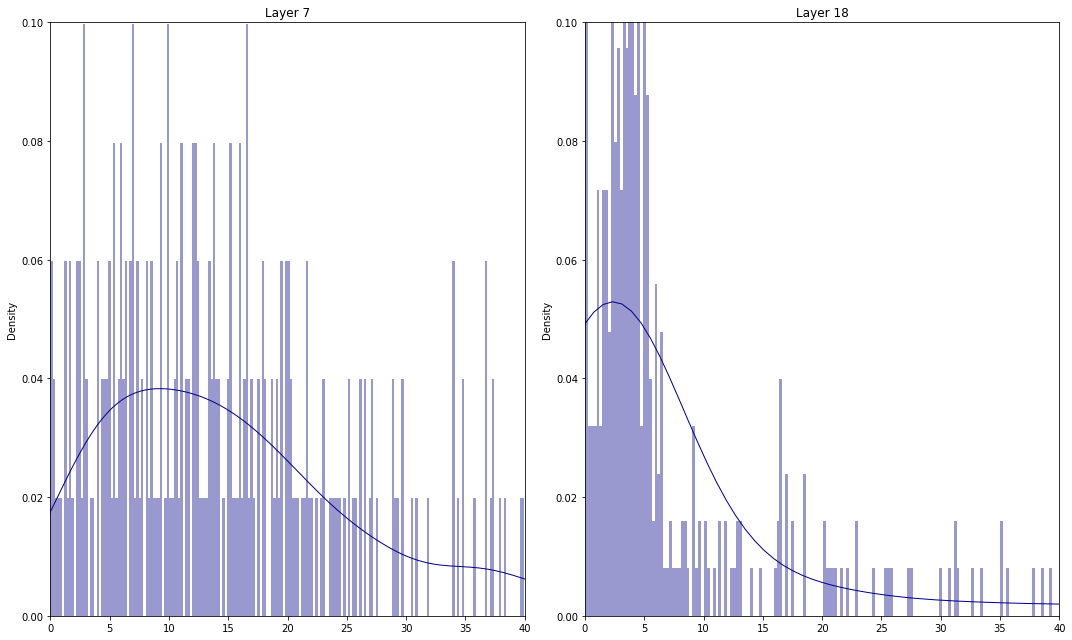

In [166]:
 
selected_idx = [6, 17]
plt.figure(figsize=(15, 9)) 
c = 0
for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
#     if layer_idx != 32:
#         plt.axis('off')
    plt.subplot(1, 2, c+1)
    c += 1
    diff = np.abs(t-a)
    sns.distplot(diff, hist=True, kde=True, 
                 bins=int(len(diff)), color = 'darkblue', 
                 kde_kws={'linewidth': 1})

    plt.xlim(0, 40)
    plt.ylim(0, 0.1)
    plt.title(f'Layer {selected_idx[layer_idx]+1}')

plt.tight_layout()

plt.savefig(f'figures/diff_histogram_vgg_{selected_idx}2.png')
plt.show()

In [ ]:

# plt.figure(figsize=(25, 15)) 
# for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
#     plt.subplot(6,6, layer_idx+1)
#     if layer_idx != 32:
#         plt.axis('off')
        
#     diff = np.abs(t-a)
#     plt.matshow(diff, fignum=False)
#     plt.title(f'Layer {layer_idx+1}')
    
# plt.tight_layout()
# # 절댓값으로도 해보기
# # 맥스 일정하게 같은 값이면 같은 색으로 보이게

# plt.savefig('figures/diff.png')
# plt.show()

In [ ]:

target09_trained_network = get_network(cfg['network'], 100)
target09_state_dict_path = 'models/pretrained/resnet34_cifar100_0~9.pt'
target09_trained_network.load_state_dict(torch.load(target09_state_dict_path),  strict=False)

In [ ]:
plt.figure(figsize=(25, 15)) 
for layer_idx in range(34):
    plt.subplot(6,6, layer_idx+1)
    if layer_idx != 32:
        plt.axis('off')
        
    target09_trained_out = get_output(target09_trained_network, layer_idx, inputs)
    target_norm = torch.norm(target09_trained_out, dim=(2,3)).detach().numpy()  # (100, 256)
    target_ranks = np.argsort(target_norm, 1) # 가장 작은 값을 가진 필터가 0, 가장 큰 값일수록 등수가 높다
    
    r_targets09.append(target_ranks)
    plt.matshow(target_ranks, fignum=False)
    plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()
plt.savefig('figures/target09_trained_fm.png')
plt.show()

In [ ]:

plt.figure(figsize=(25, 15)) 
for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
    plt.subplot(6,6, layer_idx+1)
    if layer_idx != 32:
        plt.axis('off')
        
    diff = np.abs(t-a)
    plt.matshow(diff, fignum=False)
    plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()

plt.savefig('figures/diff_histogram.png')
plt.show()

In [ ]:
# ####################################### TARGETS
# r_targets = []
# # plt.figure(figsize=(25, 15)) 
# for layer_idx in range(34):
# #     plt.subplot(6,6, layer_idx+1)
# #     if layer_idx != 32:
# #         plt.axis('off')
        
#     target_trained_out = get_output(target_trained_network, layer_idx, inputs)
#     target_norm = torch.norm(target_trained_out, dim=(2,3)).detach().numpy()  # (100, 256)
#     target_ranks = np.argsort(target_norm, 1) # 가장 작은 값을 가진 필터가 0, 가장 큰 값일수록 등수가 높다
    
#     r_targets.append(target_ranks)
# #     plt.matshow(target_ranks, fignum=False)
# #     plt.title(f'Layer {layer_idx+1}')
    
# # plt.tight_layout()
# # plt.savefig('figures/target_trained_fm.png')
# # plt.show()

In [ ]:
np.random.randint(0, 99, 5)

In [121]:
def get_inputs(dataloader):
    labels =  torch.zeros(100)
    inputs = torch.zeros(100, 3, 32, 32)
    class_idx = 0
    for i, l in dataloader.train_loader:

        if class_idx in l:
            idx = (l == class_idx).nonzero(as_tuple=True)[0][0].item()
            inputs[class_idx] = i[idx]
            labels[class_idx] = l[idx]
            class_idx += 1

        if class_idx >= 100:
            print("Done!")
            break
    print("labels: ", labels)
    return inputs

def get_output_r34(network, layer_idx, inputs):
    
    out = F.relu(network.bn1(network.conv1(inputs)))
    if layer_idx - 33 >= 0:
#         print("이건 안돼")
        pass

    elif layer_idx - 27 >= 0:
        # layer4 : 27~32
        out = network.layer1(out)
        out = network.layer2(out)
        out = network.layer3(out)
        block_idx = (layer_idx-27)//2
        for i in range(block_idx):
            out = network.layer4[i](out)
        layer = network.layer4[block_idx]

        conv_idx = (layer_idx-27)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

#         print(f"[layer4]   block{block_idx}  conv{conv_idx+1}")

    elif layer_idx - 15 >= 0:
        # layer3 : 15~26
        out = network.layer1(out)
        out = network.layer2(out)
        block_idx = (layer_idx-15)//2
        for i in range(block_idx):
            out = network.layer3[i](out)
        layer = network.layer3[block_idx]

        conv_idx = (layer_idx-15)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2
                
#         print(f"[layer3]   block{block_idx}  conv{conv_idx+1}")

    elif layer_idx - 7 >= 0:
        # layer2 : 7~14
        out = network.layer1(out)
        block_idx = (layer_idx-7)//2
        for i in range(block_idx):
            out = network.layer2[i](out)
        layer = network.layer2[block_idx]

        conv_idx = (layer_idx-7)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

#         print(f"[layer2]   block{block_idx}  conv{conv_idx+1}")
    elif layer_idx - 1 >= 0:
        # layer1 : 1~6
        block_idx = (layer_idx-1)//2
        for i in range(block_idx):
            out = network.layer1[i](out)
        layer = network.layer1[block_idx]

        conv_idx = (layer_idx-1)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

#         print(f"[layer1]   block{block_idx}  conv{conv_idx+1}")
    return out


def get_output_r18(network, layer_idx, inputs):
    
    ref1 = 1
    ref2 = 5
    ref3 = 9
    ref4 = 13
    ref5 = 17
    
    out = F.relu(network.bn1(network.conv1(inputs)))
    if layer_idx - ref5 >= 0:
#         print("이건 안돼")
        pass

    elif layer_idx - ref4 >= 0:
        # layer4 : 13~16
        out = network.layer1(out)
        out = network.layer2(out)
        out = network.layer3(out)
        block_idx = (layer_idx-ref4)//2
        for i in range(block_idx):
            out = network.layer4[i](out)
        layer = network.layer4[block_idx]

        conv_idx = (layer_idx-ref4)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

#         print(f"[layer4]   block{block_idx}  conv{conv_idx+1}")

    elif layer_idx - ref3 >= 0:
        # layer3 : 9~12
        out = network.layer1(out)
        out = network.layer2(out)
        block_idx = (layer_idx-ref3)//2
        for i in range(block_idx):
            out = network.layer3[i](out)
        layer = network.layer3[block_idx]

        conv_idx = (layer_idx-ref3)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2
                
#         print(f"[layer3]   block{block_idx}  conv{conv_idx+1}")

    elif layer_idx - ref2 >= 0:
        # layer2 : 5~8
        out = network.layer1(out)
        block_idx = (layer_idx-ref2)//2
        for i in range(block_idx):
            out = network.layer2[i](out)
        layer = network.layer2[block_idx]

        conv_idx = (layer_idx-ref2)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

#         print(f"[layer2]   block{block_idx}  conv{conv_idx+1}")
    elif layer_idx - ref1 >= 0:
        # layer1 : 1~4
        block_idx = (layer_idx-ref1)//2
        for i in range(block_idx):
            out = network.layer1[i](out)
        layer = network.layer1[block_idx]

        conv_idx = (layer_idx-ref1)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

#         print(f"[layer1]   block{block_idx}  conv{conv_idx+1}")
    return out


def get_output_vgg(network, layer_idx, inputs):
    out1 = network.features1(inputs)
    out2 = network.features2(out1)
    return out1, out2